# Ising Model のモンテカルロ・シミュレーション（Class）

Classで実装したIsing Modelのモンテカルロ・シミュレーションのコード。
コードを書いた人はClassの使い方に慣れていません。

シミュレーションできるIsing Modelの次元は引数で簡単に変えられるようにしていますが、最適化がされていないのでとても遅いコードになっています。

# Monte Carlo simulation of the Ising model implemented by Classes

Codes to simulate the Ising model of arbitrary dimensions by changing arguments.
The codes are not optimized, so they are very slow. 

In [1]:
import numpy as np

# trials
def position_as_1dim(position_tpl, lat_size):        
    position_1dim = 0
    num_of_elms = np.product(lat_size)
    tmp = 1
    for i, j in zip(position_tpl, lat_size):
        tmp *= j
        position_1dim += i * num_of_elms//tmp
    return position_1dim

def neighbor_position_1dim(position_tpl, lat_size, distance):
    lst_positions = []
    num_of_elms = np.product(lat_size)
    dim = len(lat_size)
    for cnt1 in np.arange(dim):
        position_1dim = 0
        tmp = 1
        for i, j, cnt2 in zip(position_tpl, lat_size, np.arange(dim)):
            d = distance if cnt1 == cnt2 else 0
            tmp *= j
            position_1dim += np.mod(i+d, j) * num_of_elms//tmp
        lst_positions.append(position_1dim)
    return lst_positions

In [2]:
import numpy as np
from numba import jit, jitclass, i8, f8
import matplotlib.pyplot as plt
import seaborn as sns

# main
class IsingModel_MC(object):
    def __init__(self, lat_size_lst):
        self.lat_size = lat_size_lst # list
        self.dim = len(lat_size_lst)
        self.num_of_elms = np.product(lat_size_lst)
        self.spin_config1dim = 2 * np.random.randint(0, 2, size=np.product(lat_size_lst), dtype=np.int) -1
        self.energy = 0.0
        self.coupling= 1.0
        self.ex_field = 0.0
        self.temp = 2/np.log(np.sqrt(2)+1)

    def display_heatmap(self):
        if self.dim == 2:
            plt.figure()
            sns.heatmap(self.spin_config1dim.reshape(self.lat_size),
                        cbar=False, square=True, xticklabels=False, yticklabels=False)
        else:
            print("Available for only 2 dimensions.")

    def set_energy(self):
        self.energy = 0.0
        spin_config = self.spin_config1dim.reshape(self.lat_size)
        for i in np.arange(self.dim, dtype=np.int):
            self.energy += np.sum(-self.coupling * spin_config * np.roll(spin_config, 1, axis=i))
        self.energy += np.sum(-self.ex_field * spin_config)

    def initialize(self, finite_temp = True):
        if finite_temp:
            self.spin_config1dim = 2 * np.random.randint(0, 2, size=self.num_of_elms, dtype=np.int) -1
        else:
            self.spin_config1dim = np.ones(self.num_of_elms, dtype=np.int) * np.random.choice([-1,1])
        self.set_energy()

    def _flip_spin(self, position):
        self.spin_config1dim[position] = -self.spin_config1dim[position]

    def _convert_to_tpl(self, position1dim):
        lst = []
        tmp, tmp_pos = self.num_of_elms, position1dim
        for i, j in zip(self.lat_size, np.arange(self.dim-1)):
            tmp //= i
            if j == self.dim-2:
                lst.extend(divmod(tmp_pos, tmp))
            else:
                lst.append(tmp_pos//tmp)
                tmp_pos %= tmp
        return tuple(lst)

    def _neighborhoods1dim_lst(self, position1dim, distance):
        position_tpl = self._convert_to_tpl(position1dim)
        lst_positions = []
        for cnt1 in np.arange(self.dim):
            pos1dim_minus, pos1dim_plus, tmp = 0, 0, self.num_of_elms
            for i, j, cnt2 in zip(position_tpl, self.lat_size, np.arange(self.dim)):
                d = distance if cnt1 == cnt2 else 0
                tmp //= j
                pos1dim_minus += np.mod(i-d, j) * tmp
                pos1dim_plus += np.mod(i+d, j) * tmp
            lst_positions.append(pos1dim_minus)
            lst_positions.append(pos1dim_plus)
        return lst_positions

    def update(self, steps):
        for step in np.arange(steps):
            diff_energy = 0.0
            for pos1dim in np.arange(self.num_of_elms):
                diff_energy = 2 * self.spin_config1dim[pos1dim] * (self.coupling
                                                                   * np.sum([ self.spin_config1dim[pos_nhs]
                                                                             for pos_nhs in self._neighborhoods1dim_lst(pos1dim, 1)])
                                                                   + self.ex_field)
                if (diff_energy <= 0) or (np.random.rand() < np.exp(-diff_energy/self.temp)):
                    self.energy += diff_energy
                    self._flip_spin(pos1dim)
                    
    def get_magnetization(self, interval_steps=0):
        self.update(interval_steps)
        return np.mean(self.spin_config1dim)
    
    def display_magnetization(self, temp_start_stop_step, update_steps=10, sample_size=10, sampling_interval=1):
        temp_memo = self.temp
        spin_config_memo = self.spin_config1dim
        start, stop, step = temp_start_stop_step
        temp_lst, mag_lst = np.flip(np.arange(start, stop, step)), []
        tmp_mag = 0.0
        for tmp_temp in temp_lst:
            self.temp = tmp_temp
            self.update(update_steps)
            mag_lst.append(np.mean([self.get_magnetization(sampling_interval) for _ in np.arange(sample_size)]))
        self.temp = temp_memo
        self.spin_config1dim = spin_config_memo
        # plot
        plt.plot(temp_lst, mag_lst)
        plt.grid(True)
        plt.ylabel("magnetization per cite")
        plt.xlabel("temperature")
        plt.xlim(round(temp_lst[-1],1), round(temp_lst[0],1))
        plt.show()

# Some tests

16.0
-1256.0


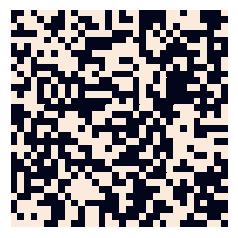

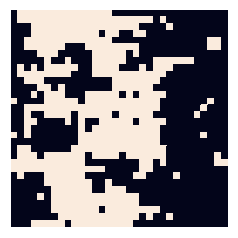

In [3]:
ising2d = IsingModel_MC((32,32))
ising2d.initialize()
print(ising2d.energy)
ising2d.display_heatmap()
ising2d.update(10)
ising2d.display_heatmap()
print(ising2d.energy)

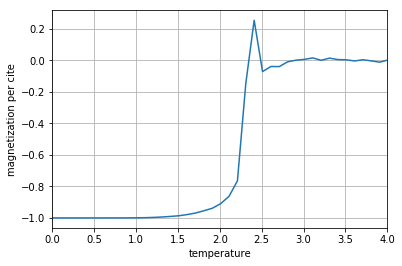

CPU times: user 40min, sys: 500 ms, total: 40min
Wall time: 40min 1s


In [4]:
%%time
ising2d.display_magnetization([0.01, 4.1, 0.1], update_steps=100, sample_size=400)

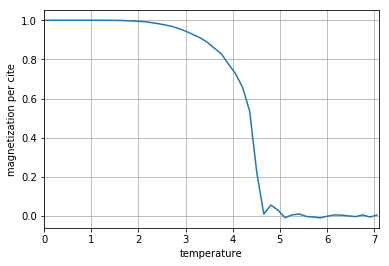

CPU times: user 1h, sys: 1.88 s, total: 1h 2s
Wall time: 1h 2s


In [194]:
%%time
ising3d = IsingModel_MC((16,16,16))
ising3d.initialize()
ising3d.display_magnetization([0.01, 7.2, 0.15], update_steps=40, sample_size=60)